# Flight Management System for airborne wildfire response

This example demonstrates episodic stress testing of a flight mangement system (FMS). The FMS maintains flight plans for a set of aircraft, indicating position and time of various waypoints. The FMS collision detection module (CDM) solves the system of plans to analytically determine the closest approach among the set of aircraft, assuming they travel linearly between waypoints. In this example, the FMS is tasked with managing a wildfire response. A complex mission might require a large number of airborne resources whose flight plans may change dynamically based on a rapidly evolving situation on the ground. The FMS must be able to evaluate the safety and suitability of the flight plans with each update.

- **System under test:** inactive; FMS does nothing to actively modify flight plans or avoid failures.
- **Failure criterion:** CDM warns that the current flight plans cause two aircraft to come within critical distance of each other.
- **Stochastic disturbance:** waypoint selection, converted into a sequential problem. Sequential waypoints are separated in distance by a 2-dimensional zero-mean normal distribution and in time by a 1-dimensional non-zero-mean normal distribution, truncated to remain positive.

Note that no actual "stepping" is occurring in the FMS. Rather, the simulation is sequentially constructing a set of flight plans to be submitted to the CDM for analysis at the final step. We can treat this problem as an MDP and leverage AdaStress solvers to efficiently find a solution.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../..")
Pkg.instantiate()

  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\fms`
   Resolving package versions...
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\fms\Project.toml`
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\fms\Manifest.toml`


In [2]:
using AdaStress
using Distributions
using IterTools
using LinearAlgebra
using Plots
using Random
using StaticArrays

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


## FMS

In [3]:
"""
A waypoint consists of cartesian coordinates and time of arrival.
"""
mutable struct Waypoint
    s::SVector{2, Float64} # coordinates [miles]
    t::Float64             # time [minutes]
end

"""
A flight plan is a set of sequential waypoints.
"""
Base.@kwdef mutable struct Plan
    waypoints::Vector{Waypoint} = Vector{Waypoint}()
end

Plan

## Collision detection module

In [4]:
struct CollisionModule
    d_crit::Float64 # critical separation threshold [miles]
end

"""
Computes minimum separation between linear segment a1 -> b1 and a2 -> b2, where transition takes place
over normalized time range τ ∈ [0, 1].
"""
function tau_min_sep(a1::T, b1::T, a2::T, b2::T) where T <: AbstractVector
    Δ = (b1 - a1) - (b2 - a2)
    tau = (a2 - a1) ⋅ Δ / (Δ ⋅ Δ)
    return clamp(tau, 0, 1)
end

"""
Computes overlap of two ranges.
"""
function overlap(r1::Tuple, r2::Tuple)
    l = max(r1[1], r2[1])
    u = min(r1[2], r2[2])
    return l < u ? (l, u) : nothing
end

"""
Iterates over all adjacent elements of vector.
"""
transitions(v::AbstractVector) = zip(v[1:end-1], v[2:end])

"""
Performs linear interpolation.
"""
interpolate(t::Float64, ts::Tuple, vs::Tuple) = vs[1] + (vs[2] - vs[1]) * (t - ts[1]) / (ts[2] - ts[1])

distance(v1::AbstractVector, v2::AbstractVector) = norm(v1 - v2)

"""
Computes closest approach between two pairs of waypoints. If time ranges are disjoint, returns Inf.
"""
function closest(pair1::NTuple{2, Waypoint}, pair2::NTuple{2, Waypoint})
    pos = w -> w.s
    tim = w -> w.t
    s1, t1 = pos.(pair1), tim.(pair1)
    s2, t2 = pos.(pair2), tim.(pair2)
    to = overlap(t1, t2)
    to === nothing && return Inf

    x1 = (interpolate(b, t1, s1) for b in to)
    x2 = (interpolate(b, t2, s2) for b in to)
    τ = tau_min_sep(x1..., x2...)
    tc = to[1] + τ * (to[2] - to[1])
    c1 = interpolate(tc, t1, s1)
    c2 = interpolate(tc, t2, s2)
    return distance(c1, c2)
end

"""
Computes analytical closest approach between two plans. Returns minimum distance and respective waypoint pairs.
"""
function closest(plan1::Plan, plan2::Plan)
    dmin = Inf
    best_pairs = nothing
    
    for pair1 in transitions(plan1.waypoints)
        for pair2 in transitions(plan2.waypoints)
            pair1[2].t <= pair2[1].t && break # look no further, since Δt is guaranteed > 0
            d = closest(pair1, pair2)
            if d < dmin
                dmin = d
                best_pairs = (pair1, pair2)
            end
        end
    end
        
    return dmin, best_pairs
end

"""
Computes analytical closest approach across set of plans. Returns minimum distance and respective waypoint pairs.
"""
function closest(plans::Vector{Plan})
    dmin = Inf
    best_pairs = nothing
    
    for (plan1, plan2) in subsets(plans, 2)
        d, pairs = closest(plan1, plan2)
        if d < dmin
            dmin = d
            best_pairs = pairs
        end
    end
    
    return dmin, best_pairs
end

"""
Evaluates collision module with set of plans. Returns whether a collision is expected and the miss distance.
"""
function evaluate(col::CollisionModule, plans::Vector{Plan}; verbose::Bool=false)
    dt = @elapsed d_min, _ = closest(plans)
    failure = d_min <= col.d_crit
    if verbose
        in_feet = d -> round(5280 * d; digits=1)
        println("Plan solved in $dt seconds.")
        println(failure ? "Collision detected." : "No collision detected.")  
        println("CDS separation threshold: $(in_feet(col.d_crit)) ft")
        println("Sep. at closest approach: $(in_feet(d_min)) ft")
    end    
    return failure, d_min
end

evaluate

## Simulation

In [5]:
"""
Initial position of aircrafts, determined by Gaussian spread.
"""
function initial_plans(num_aircraft::Int64, σ::Float64)
    #TODO: fix issue of not being able to set global RNG in `reset!`
    Random.seed!(0)
    plans = [Plan() for _ in 1:num_aircraft]
    for plan in plans
        start = σ * randn(2)
        push!(plan.waypoints, Waypoint(start, 0.0))
    end
    return plans
end

Base.@kwdef mutable struct FMSim <: Interface.BlackBox
    num_steps::Int64     = 25                                # number of waypoints
    num_aircraft::Int64  = 2                                 # number of aircraft (must be >=2)
    step::Int64          = 0
    σ::Float64           = 10.0                              # initial spread [miles]
    inits::Vector{Plan}  = initial_plans(num_aircraft, σ)
    plans::Vector{Plan}  = deepcopy(inits)
    Δs::Distribution     = MvNormal([0.5, 0.5])              # spatial difference distribution [miles]
    Δt::Distribution     = Truncated(Normal(1, 0.25), 0, 1)  # time difference distribution [minutes]
    d_min::Float64       = NaN
    col::CollisionModule = CollisionModule(0.1)              # collision detection module
    analyzed::Bool       = false                              
    failure::Bool        = false
end

FMSim

In [6]:
function Interface.reset!(sim::FMSim)
    sim.step = 0
    sim.analyzed = false
    sim.d_min = NaN
    sim.plans = deepcopy(sim.inits)
end

marginal_logprob(d::Distribution, val::Any) = logpdf(d, val) - logpdf(d, mode(d))

function Interface.step!(sim::FMSim)
    sim.step += 1
    logprob = 0.0
    for plan in sim.plans
        prev = plan.waypoints[end]
        ds = rand(sim.Δs)
        dt = rand(sim.Δt)
        push!(plan.waypoints, Waypoint(prev.s + ds, prev.t + dt))
        logprob += marginal_logprob(sim.Δs, ds) + marginal_logprob(sim.Δt, dt)
    end
    return logprob
end

function Interface.isterminal(sim::FMSim)
    #TODO: fix issue of `isterminal` being called multiple times
    done = sim.step >= sim.num_steps
    if done && !sim.analyzed
        sim.failure, sim.d_min = evaluate(sim.col, sim.plans)
        sim.analyzed = true
    end
    return done
end

Interface.isevent(sim::FMSim) = sim.failure

Interface.distance(sim::FMSim) = sim.d_min

## Solver

In [7]:
mdp = Interface.ASTMDP(FMSim(; num_aircraft=2); episodic=true)
mdp.reward.event_bonus = 100.0

100.0

In [8]:
mcts = AdaStress.Solvers.MCTS(num_iterations=100_000)

AdaStress.Solvers.MonteCarloTreeSearch.MCTS(100000, 10, 1.0, 0.7, 1.0, nothing)

In [9]:
Random.seed!(0)
@time sol = mcts(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:0939mm39m


 10.501736 seconds (139.77 M allocations: 6.454 GiB, 10.73% gc time, 21.19% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.892
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.8928
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.9045
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.9092
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.9327
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.9383
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.9467
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.962
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 73.9684
  MCTSResult(UInt32[0xaa01c11f, 0x75ac8a97, 0x90db374b, 0x77809412, … => 74.0108

## Visualization

In [10]:
function visualize(sim::FMSim)
    # all plans
    p = plot(; aspect_ratio=:equal, legend=:bottomright)
    for (i, plan) in enumerate(sim.plans)
        xs = [w.s[1] for w in plan.waypoints]
        ys = [w.s[2] for w in plan.waypoints]
        plot!(p, xs, ys; label="aircraft $i")
    end
    
    # segment of closest approach
    _, pairs = closest(sim.plans)
    for pair in pairs
        xs = [pair[1].s[1], pair[2].s[1]]
        ys = [pair[1].s[2], pair[2].s[2]]
        plot!(p, xs, ys; lc=:red, lw=3, label=:none)
    end
    evaluate(sim.col, sim.plans; verbose=true) # unnecessary but for show
    
    return p
end

visualize (generic function with 1 method)

Plan solved in 9.7e-6 seconds.
Collision detected.
CDS separation threshold: 528.0 ft
Sep. at closest approach: 226.3 ft


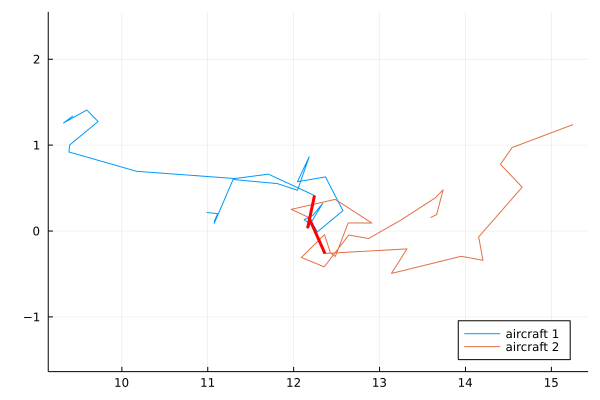

In [11]:
best_path = last(collect(keys(sol)))
AdaStress.Solvers.replay!(mdp, best_path)
visualize(mdp.sim)